# Import packages and data

In [54]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from collections import defaultdict
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.decomposition import PCA
import shap

In [55]:
file_path = 'cleaned_data_no_injured.xlsx'

# Load the CSV into a DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame
df.head()

,DATE,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,PlayerID,...,Position_WINGER,Microcycle_M+1,Microcycle_M+2,Microcycle_M+3,Microcycle_M-1,Microcycle_M-2,Microcycle_M-3,Microcycle_M-4,Microcycle_M-5,Microcycle_MD
0,2021-08-12,0,2021-2022,SEASON,1701.0,0.0,0,14.0,7.0,10103,...,0,0,0,0,0,0,0,0,0,0
1,2021-08-13,0,2021-2022,SEASON,3593.0,54.0,1,45.0,22.0,10103,...,0,0,0,0,0,1,0,0,0,0
2,2021-08-15,0,2021-2022,SEASON,5802.0,92.0,0,94.0,53.0,10103,...,0,0,0,0,1,0,0,0,0,0
3,2021-08-17,0,2021-2022,SEASON,6056.0,275.0,44,74.0,60.0,10103,...,0,1,0,0,0,0,0,0,0,0
4,2021-08-18,0,2021-2022,SEASON,5985.0,288.0,154,73.0,79.0,10103,...,0,0,0,0,0,0,0,1,0,0


Class imbalance:

In [56]:
print("No Lesión: " + str(df[df["Injury"] == 0].shape[0]))
print("Lesión: " + str(df[df["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df[df['Injury'] == 1].shape[0] / df.shape[0]) * 100):.2f}%")

No Lesión: 4381
Lesión: 36
Porcentaje de lesionados en el dataset: 0.82%


# Correlation of variables

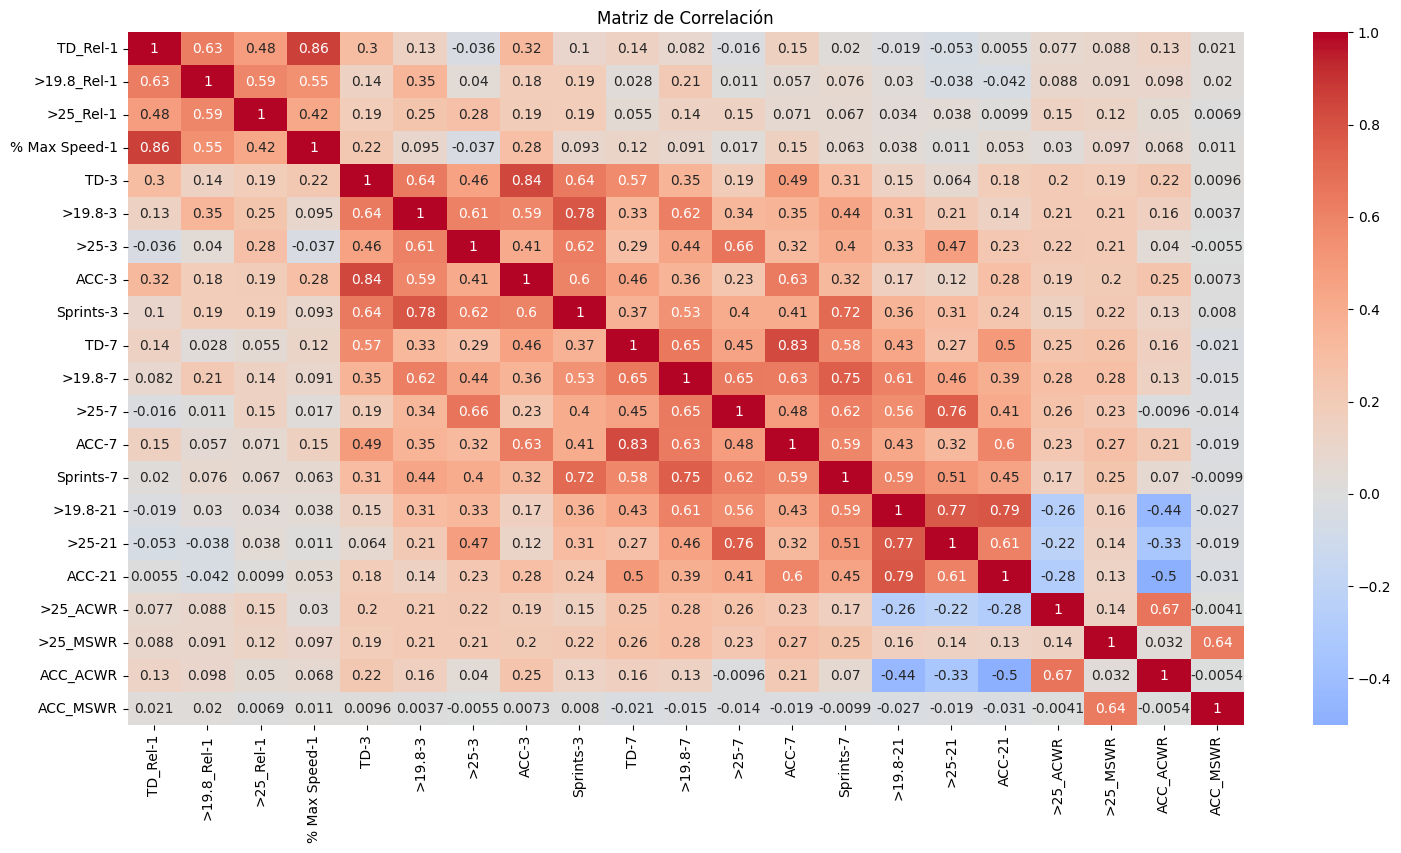

In [ ]:
metrics = ['TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
       'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
       'Sprints-7', '>19.8-21', '>25-21', 'ACC-21', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR']

# Calcular la matriz de correlación
correlation_matrix = df[metrics].corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(18, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


In [ ]:
df_with_constant = add_constant(df[metrics])

# Calcular el VIF para cada columna
vif_data = pd.DataFrame()
vif_data["Variable"] = df_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                   for i in range(df_with_constant.shape[1])]

# Mostrar el VIF
print(vif_data)

         Variable        VIF
0           const  37.345933
1        TD_Rel-1   5.109646
2     >19.8_Rel-1   2.770056
3       >25_Rel-1   1.909037
4   % Max Speed-1   3.997180
5            TD-3   9.880922
6         >19.8-3   7.585732
7           >25-3   4.094357
8           ACC-3   8.506115
9       Sprints-3  11.870469
10           TD-7   8.552423
11        >19.8-7   8.124830
12          >25-7   7.695737
13          ACC-7  11.795012
14      Sprints-7   9.889881
15       >19.8-21   7.369543
16         >25-21   6.673095
17         ACC-21   7.925699
18       >25_ACWR   3.024686
19       >25_MSWR   2.158119
20       ACC_ACWR   4.133702
21       ACC_MSWR   1.880967


# Filter data by date or season


In [57]:
# Season 2022-2023
# df_filtered = df[df['season']=='2022-2023']

# inj_2021 = df[(df['Injury'] == 1) & (df['season'] == '2021-2022')]
# df_filtered = pd.concat([df_filtered, inj_2021])

# Season 2021-2022
# df_filtered = df[df['season']=='2021-2022']

# Filter by no season
df_filtered = df.copy()

df_filtered = df_filtered[df_filtered['preseason-season'] != 'PRESEASON']

df_filtered.reset_index(drop=True, inplace=True)

df_sorted = df_filtered.sort_values(by='DATE', ascending=False).reset_index(drop=True)

# ML Models

## Select metrics to use for models

In [58]:
df.columns

Index(['DATE', 'Injury', 'season', 'preseason-season', 'TD', '>19.8', '>25',
       'ACC', 'DEC', 'PlayerID', 'Max Speed', 'Sprints', 'Mins',
       'Max Speed Season', 'Avg Speed Season', '% Max Speed',
       'Speed Diff Max Avg', 'TD_Rel', '>19.8_Rel', '>25_Rel', 'ACC_Rel',
       'DEC_Rel', 'TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
       'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
       'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
       'DEC-3', 'Sprints-3', 'Mins-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
       'DEC-7', 'Sprints-7', 'Mins-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21', 'Mins-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
       '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
       'DEC_ACWR', 'DEC_MSWR', 'Position_CENTREBACK',
       'Position_CENTREMIDFIELDER', 'Position_FULLBACK', 'Position_STRIKER',
       'Position_WINGER', 'Microcycle_M+1', 'Microcycle_M+2', 'Micr

In [59]:
# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'Mins-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'Mins-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'Mins-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

# All data (Microcycles included)
# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR','Microcycle_M+1', 'Microcycle_M+2', 'Microcycle_M+3',
#        'Microcycle_M-1', 'Microcycle_M-2', 'Microcycle_M-3', 'Microcycle_M-4',
#        'Microcycle_M-5', 'Microcycle_MD']

# No microcycle data
# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1','Mins-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

## No microcycle data and no -21 data
metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
       'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
       'DEC_Rel-1', '% Max Speed-1','Mins-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
       'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
       'DEC-7', 'Sprints-7', 'TD_MSWR','>19.8_MSWR','>25_MSWR', 'ACC_MSWR','DEC_MSWR']


# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'Sprints-1',
#        'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR']

# metrics_train = ['Injury', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'Sprints-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'Sprints-7', '>19.8-21', '>25-21', 'ACC-21', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR']

# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

print(len(metrics_train))

31


## Split data

### Split by selecting X injuries and its past X days for testing the model, the rest of the injuries and its past X rows as training dataset.

In [62]:
import random

# Ensure the data is sorted by PlayerID and DATE
df_sorted = df_sorted.sort_values(by=['PlayerID', 'DATE']).reset_index(drop=True)

# Parameter: Number of injuries for the test set
num_test_injuries = 7  # Number of injuries to include in the test set

# Identify rows where `Injury` occurred (Injury == 1)
injury_rows = df_sorted[df_sorted['Injury'] == 1]

# Step 1: Randomly select indices for testing and training injuries
random.seed(42)  # Set seed for reproducibility
all_injury_indices = list(injury_rows.index)
test_injury_indices = random.sample(all_injury_indices, num_test_injuries)
train_injury_indices = list(set(all_injury_indices).difference(test_injury_indices))

# Step 2: Collect rows for testing set
test_indices = set(test_injury_indices)  # Start with rows where Injury == 1
rows_before_test = 10

for idx in test_injury_indices:
    player_id = df_sorted.loc[idx, 'PlayerID']
    player_data = df_sorted[df_sorted['PlayerID'] == player_id]

    # Find the position of the current injury in the player's data
    injury_pos = player_data.index.get_loc(idx)

    # Collect the previous rows (or as many as available)
    past_rows = player_data.iloc[max(0, injury_pos - rows_before_test):injury_pos].index.tolist()
    test_indices.update(past_rows)

# Step 3: Collect rows for training set
train_indices = set(train_injury_indices)  # Start with rows where Injury == 1
rows_before_train = 30

for idx in train_injury_indices:
    player_id = df_sorted.loc[idx, 'PlayerID']
    player_data = df_sorted[df_sorted['PlayerID'] == player_id]

    # Find the position of the current injury in the player's data
    injury_pos = player_data.index.get_loc(idx)

    # Collect the previous rows (or as many as available)
    past_rows = player_data.iloc[max(0, injury_pos - rows_before_train):injury_pos].index.tolist()
    train_indices.update(past_rows)

# Step 4: Remove duplicates from indices and ensure no overlap
test_indices = list(test_indices)
train_indices = list(set(train_indices).difference(test_indices))

# Step 5: Create the datasets
training = df_sorted.loc[train_indices]
testing = df_sorted.loc[test_indices]


# Get the columns in metrics_train and add the required columns
columns_to_keep = list(metrics_train) + ['PlayerID', 'DATE']

# Ensure there are no duplicates in the list
columns_to_keep = list(set(columns_to_keep))

X_train = training[metrics_train].reset_index(drop=True)
X_test_original = testing[columns_to_keep].reset_index(drop=True)
X_test = testing[metrics_train].reset_index(drop=True)
y_train = training['Injury'].reset_index(drop=True)
y_test = testing['Injury'].reset_index(drop=True)

In [13]:
# # Check for overlap between X_train and X_test
# common_rows = pd.merge(X_train, X_test, on=['DATE', 'PlayerID'], how='inner')

# if common_rows.empty:
#     print("No overlapping rows between X_train and X_test based on DATE and PlayerID.")
# else:
#     print("Overlapping rows found between X_train and X_test:")
#     print(common_rows)

In [63]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")
print("No Lesión: " + str(X_test[X_test["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_test[X_test["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_test[X_test['Injury'] == 1].shape[0] / X_test.shape[0]) * 100):.2f}%")
X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

No Lesión: 782
Lesión: 28
Porcentaje de lesionados en el dataset: 3.46%
No Lesión: 70
Lesión: 7
Porcentaje de lesionados en el dataset: 9.09%


### Split by first %X for validating and rest for training

In [18]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

# Determine the split index for X% testing
percentage_validation = 0.3
split_index = int(percentage_validation * len(df_sorted))

# Split the data
X_test = X.iloc[:split_index].reset_index(drop=True)
X_train = X.iloc[split_index:].reset_index(drop=True)
y_test = y.iloc[:split_index].reset_index(drop=True)
y_train = y.iloc[split_index:].reset_index(drop=True)
extra_cols_test = extra_cols.iloc[:split_index].reset_index(drop=True)
extra_cols_train = extra_cols.iloc[split_index:].reset_index(drop=True)

Select less amount of data

In [ ]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")

No Lesión: 2883
Lesión: 22
Porcentaje de lesionados en el dataset: 0.76%


In [ ]:
# Sort X_train by index
X_train = X_train.sort_index()  # Sort by date or relevant index if not already sorted.
y_train = y_train.sort_index()  # Ensure y_train matches X_train in order.

# Filter rows where 'Injury' == 1
injury_rows = X_train[X_train['Injury'] == 1]

# Get 30 days before each injury
# Assuming a datetime index, otherwise adjust for your date representation
indices_to_include = set(injury_rows.index)

for idx in injury_rows.index:
    # Include 30 rows before the 'Injury == 1', ensure not out of bounds
    start_idx = max(0, idx - 30)
    indices_to_include.update(range(start_idx, idx + 1))

# Create a dataframe with required rows (Injury == 1 and 30 days before)
selected_rows = X_train.loc[list(indices_to_include)]
selected_y = y_train.loc[selected_rows.index]  # Match y_train with selected rows

# Get the remaining rows not in `selected_rows`
remaining_rows = X_train.drop(selected_rows.index)
remaining_y = y_train.drop(selected_y.index)

# Proportion for sampling (e.g., 50%)
sample_proportion = 0.5
n_to_sample = int(len(X_train) * sample_proportion - len(selected_rows))

# Randomly sample from the remaining rows
sampled_rows = remaining_rows.sample(n=n_to_sample, random_state=42)
sampled_y = remaining_y.loc[sampled_rows.index]

# Combine the selected rows and sampled rows
X_train = pd.concat([selected_rows, sampled_rows]).sort_index().reset_index(drop=True)
y_train = pd.concat([selected_y, sampled_y]).sort_index().reset_index(drop=True)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Injury      809 non-null    int64  
 1   TD-1        809 non-null    float64
 2   >19.8-1     809 non-null    int64  
 3   >25-1       809 non-null    int64  
 4   ACC-1       809 non-null    float64
 5   DEC-1       809 non-null    float64
 6   Sprints-1   809 non-null    int64  
 7   TD-3        809 non-null    float64
 8   >19.8-3     809 non-null    float64
 9   >25-3       809 non-null    int64  
 10  ACC-3       809 non-null    float64
 11  DEC-3       809 non-null    float64
 12  Sprints-3   809 non-null    int64  
 13  TD-7        809 non-null    float64
 14  >19.8-7     809 non-null    float64
 15  >25-7       809 non-null    int64  
 16  ACC-7       809 non-null    float64
 17  DEC-7       809 non-null    float64
 18  Sprints-7   809 non-null    int64  
 19  TD-21       809 non-null    f

In [ ]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")

No Lesión: 789
Lesión: 20
Porcentaje de lesionados en el dataset: 2.47%


In [ ]:
X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

### Split random

In [61]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[list(metrics_train) + ['PlayerID', 'DATE']]
y = df_sorted['Injury']

# Split the data into training and test sets
# X_train, X_test, y_train, y_test, extra_cols_train, extra_cols_test = train_test_split(X, y, extra_cols, test_size=0.3, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_test_original = X_test.copy()

X_train.drop(columns=['Injury', 'PlayerID', 'DATE'], inplace=True)
X_test.drop(columns=['Injury', 'PlayerID', 'DATE'], inplace=True)

## SMOTE or SMOTEEN oversampling technique

In [64]:
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train , y_train = smote.fit_resample(X_train, y_train)

# Apply SMOTEEN to training data
# smote_enn = SMOTEENN(random_state=42)
# X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts())

Class distribution after SMOTE:
Injury
0    782
1    782
Name: count, dtype: int64
Injury
0    782
1    782
Name: count, dtype: int64


## Standarizacion

#### CON Microcycles en data

In [ ]:
no_scaled = ['Microcycle_M+1', 'Microcycle_M+2', 'Microcycle_M+3',
       'Microcycle_M-1', 'Microcycle_M-2', 'Microcycle_M-3', 'Microcycle_M-4',
       'Microcycle_M-5', 'Microcycle_MD']

# Initialize the scaler
scaler = StandardScaler()

# Columns to scale: exclude those in no_scaled
scaled_columns = [col for col in X_train.columns if col not in no_scaled]

# Scale only the selected columns
X_train_scaled_part = scaler.fit_transform(X_train[scaled_columns])
X_test_scaled_part = scaler.transform(X_test[scaled_columns])

# Convert scaled parts back to DataFrame
X_train_scaled_part = pd.DataFrame(X_train_scaled_part, columns=scaled_columns, index=X_train.index)
X_test_scaled_part = pd.DataFrame(X_test_scaled_part, columns=scaled_columns, index=X_test.index)

# Add the unscaled columns back
X_train_scaled = pd.concat([X_train_scaled_part, X_train[no_scaled]], axis=1)
X_test_scaled = pd.concat([X_test_scaled_part, X_test[no_scaled]], axis=1)

# Ensure column order matches the original
X_train_scaled = X_train_scaled[X_train.columns]
X_test_scaled = X_test_scaled[X_test.columns]

#### Sin microcycles en metricas

In [28]:
# Initialize the scaler
scaler = StandardScaler()

# Scale only the selected columns
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression

### Regular logistic regression

In [ ]:
# Create the model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
logistic_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = logistic_model.predict(X_train_scaled)
y_test_pred = logistic_model.predict(X_test_scaled)

# Probabilities
y_test_probs = logistic_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

# Training evaluation
print("Training Set Evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# Test evaluation
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Training Set Evaluation:
Accuracy: 0.8543516873889876
Confusion Matrix:
 [[451 112]
 [ 52 511]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85       563
           1       0.82      0.91      0.86       563

    accuracy                           0.85      1126
   macro avg       0.86      0.85      0.85      1126
weighted avg       0.86      0.85      0.85      1126


Test Set Evaluation:
Accuracy: 0.6753246753246753
Confusion Matrix:
 [[48 22]
 [ 3  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.69      0.79        70
           1       0.15      0.57      0.24         7

    accuracy                           0.68        77
   macro avg       0.55      0.63      0.52        77
weighted avg       0.87      0.68      0.74        77



Find the best threshold

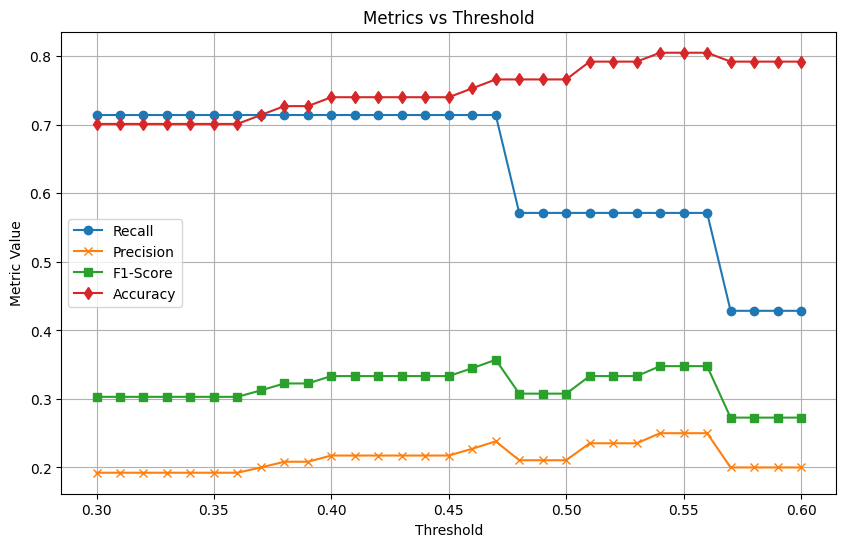

In [ ]:
# Thresholds to evaluate (from 0.3 to 0.6 in steps of 0.01)
thresholds = np.arange(0.3, 0.61, 0.01)  # Thresholds from 0 to 1 in steps of 0.01

# Store results
results = []

for threshold in thresholds:
    # Generate predictions for the current threshold
    y_pred = (y_test_probs >= threshold).astype(int)

    # Calculate metrics
    recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for label 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Append metrics and threshold to results
    results.append({
        'Threshold': threshold,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'Accuracy': accuracy
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='x')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='s')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='d')
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Threshold")
plt.legend()
plt.grid()
plt.show()

ROC Curve with manually selecting the threshold

Number of unique thresholds: 13

Manually Selected Threshold: 0.40

Evaluation with Manually Selected Threshold:
Accuracy: 0.7402597402597403
Confusion Matrix:
 [[52 18]
 [ 2  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.74      0.84        70
           1       0.22      0.71      0.33         7

    accuracy                           0.74        77
   macro avg       0.59      0.73      0.59        77
weighted avg       0.90      0.74      0.79        77



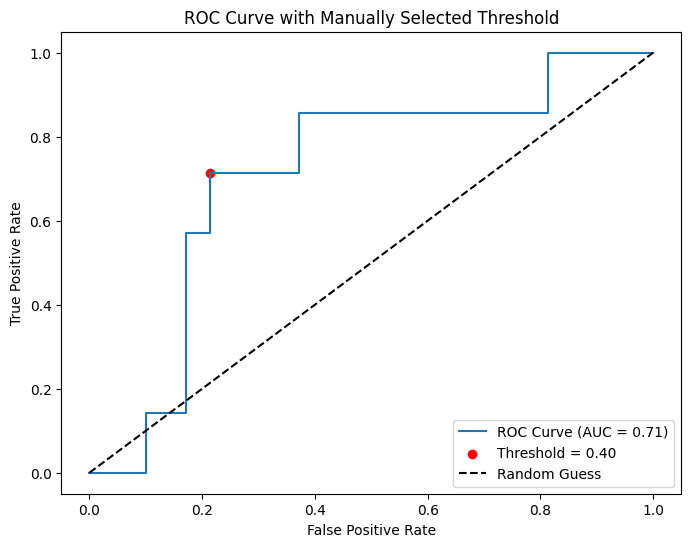

In [ ]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

# Print the number of unique thresholds
print(f"Number of unique thresholds: {len(thresholds)}")

# Manually select the threshold
manual_threshold = 0.4 # Manually chosen threshold
print(f"\nManually Selected Threshold: {manual_threshold:.2f}")

# Apply the manually selected threshold
y_test_pred_manual = (y_test_probs >= manual_threshold).astype(int)

# Evaluate the model with the manually selected threshold
print("\nEvaluation with Manually Selected Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_manual))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_manual))
print("Classification Report:\n", classification_report(y_test, y_test_pred_manual))

# Find the index of the manually selected threshold in the ROC data
# Using `thresholds` from the ROC calculation
manual_idx = np.argmin(np.abs(thresholds - manual_threshold))

# Plot the ROC curve and mark the manually selected threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[manual_idx], tpr[manual_idx], color="red", label=f"Threshold = {manual_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Manually Selected Threshold")
plt.legend(loc="lower right")
plt.show()

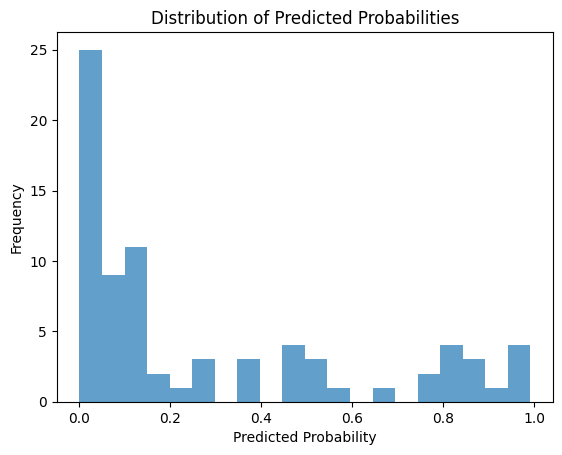

In [ ]:
plt.hist(y_test_probs, bins=20, alpha=0.7)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

Store the coeficients

In [ ]:
# Reset index for consistency
extra_cols_test.reset_index(inplace=True, drop=True)

# Get coefficients and intercept
coefficients = logistic_model.coef_[0]  # Coefficients
intercept = logistic_model.intercept_[0]  # Intercept
features = X_test.columns  # Feature names

# Create the player-score DataFrame
df_a = pd.DataFrame({
    'Player': extra_cols_test['PlayerID'],
    'Date': extra_cols_test['DATE'],
    'Score': y_test_probs,
    'Actual': y_test.reset_index(drop=True)
})

# Add feature values and calculate z (linear combination)
for i, feature in enumerate(features):
    df_a[feature] = X_test_scaled[:, i]  # Add scaled feature values
    df_a[f'Coeff_{feature}'] = coefficients[i]  # Add coefficient for each feature

# Calculate the linear combination (z) for each row
df_a['Linear_Combination'] = (
    np.dot(X_test_scaled, coefficients) + intercept
)

# Display the resulting DataFrame
print("\nPlayer, Date, Feature Contributions, Linear Combination, and Score DataFrame:")
df_a.head()


NameError: name 'extra_cols_test' is not defined

Find the features that affect the injuries the most

In [ ]:
# Assuming your features are in a DataFrame
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,  # Replace with your feature names
    "Importance": logistic_model.coef_[0]  # Coefficients from logistic regression
})

# Sort by importance
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Display the feature importance
print(feature_importance)

           Feature  Importance
24       Sprints-7    2.161744
7         TD_Rel-1    1.878728
4            DEC-1    1.585965
27          >25-21    1.453410
31         TD_ACWR    1.439439
12   % Max Speed-1    1.173611
13            TD-3    1.149488
35        >25_ACWR    0.937900
40        DEC_MSWR    0.836031
16           ACC-3    0.697221
15           >25-3    0.558649
22           ACC-7    0.438215
23           DEC-7    0.391108
38        ACC_MSWR    0.373578
2            >25-1    0.341091
14         >19.8-3    0.181219
36        >25_MSWR    0.164959
5        Sprints-1    0.130115
29          DEC-21    0.075791
33      >19.8_ACWR   -0.016715
39        DEC_ACWR   -0.086644
20         >19.8-7   -0.092862
8      >19.8_Rel-1   -0.127035
28          ACC-21   -0.299928
25           TD-21   -0.340709
11       DEC_Rel-1   -0.420705
6           Mins-1   -0.542277
19            TD-7   -0.560830
3            ACC-1   -0.579644
26        >19.8-21   -0.641157
17           DEC-3   -0.712210
1       

Select X quantity of the top features and retrain the model

In [ ]:
# Extract top features by absolute importance
num_top_features =  20 # Adjust this to include the number of features you want
top_features = feature_importance.iloc[:num_top_features]["Feature"].values

print(f"Selected Top {num_top_features} Features: {top_features}")

Selected Top 20 Features: ['Sprints-7' 'TD_Rel-1' 'DEC-1' '>25-21' 'TD_ACWR' '% Max Speed-1' 'TD-3'
 '>25_ACWR' 'DEC_MSWR' 'ACC-3' '>25-3' 'ACC-7' 'DEC-7' 'ACC_MSWR' '>25-1'
 '>19.8-3' '>25_MSWR' 'Sprints-1' 'DEC-21' '>19.8_ACWR']


In [ ]:
# Filter the training and testing data for top features
X_train_top = X_train_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]
X_test_top = X_test_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]

# Train logistic regression with top features
logistic_model_top = LogisticRegression(random_state=42, max_iter=1000)
logistic_model_top.fit(X_train_top, y_train)

# Predictions
y_test_pred_top = logistic_model_top.predict(X_test_top)
y_test_probs_top = logistic_model_top.predict_proba(X_test_top)[:, 1]

# Evaluate performance
print("Updated Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_top))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_top))
print("Classification Report:\n", classification_report(y_test, y_test_pred_top))

# Thresholds to evaluate (from 0.3 to 0.6 in steps of 0.01)
thresholds = np.arange(0.3, 0.61, 0.01)  # Thresholds from 0 to 1 in steps of 0.01

# Store results
results = []

for threshold in thresholds:
    # Generate predictions for the current threshold
    y_pred = (y_test_probs_top >= threshold).astype(int)

    # Calculate metrics
    recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for label 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Append metrics and threshold to results
    results.append({
        'Threshold': threshold,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'Accuracy': accuracy
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='x')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='s')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='d')
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Threshold")
plt.legend()
plt.grid()
plt.show()

InvalidIndexError: (slice(None, None, None), [24, 7, 4, 27, 31, 12, 13, 35, 40, 16, 15, 22, 23, 38, 2, 14, 36, 5, 29, 33])

Number of unique thresholds: 11

Manually Selected Threshold: 0.40

Evaluation with Manually Selected Threshold:
Accuracy: 0.43636363636363634
Confusion Matrix:
 [[20 30]
 [ 1  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.40      0.56        50
           1       0.12      0.80      0.21         5

    accuracy                           0.44        55
   macro avg       0.54      0.60      0.38        55
weighted avg       0.88      0.44      0.53        55



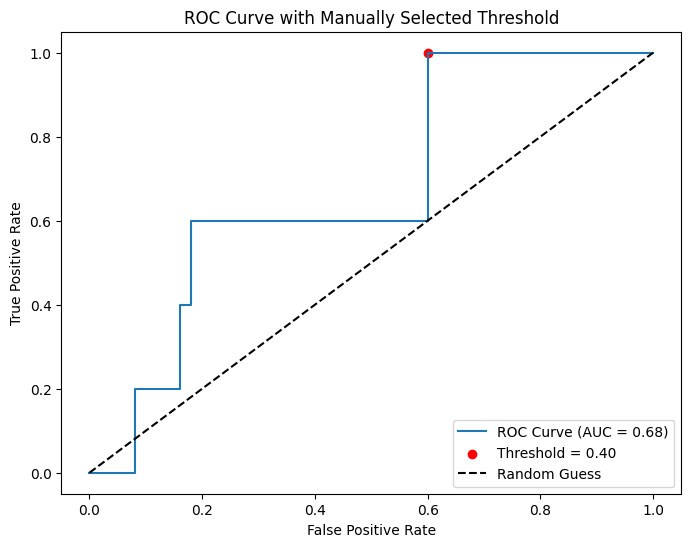

In [ ]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs_top)
roc_auc = auc(fpr, tpr)

# Print the number of unique thresholds
print(f"Number of unique thresholds: {len(thresholds)}")

# Manually select the threshold
manual_threshold = 0.4  # Manually chosen threshold
print(f"\nManually Selected Threshold: {manual_threshold:.2f}")

# Apply the manually selected threshold
y_test_pred_manual = (y_test_probs_top >= manual_threshold).astype(int)

# Evaluate the model with the manually selected threshold
print("\nEvaluation with Manually Selected Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_manual))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_manual))
print("Classification Report:\n", classification_report(y_test, y_test_pred_manual))

# Find the index of the manually selected threshold in the ROC data
# Using `thresholds` from the ROC calculation
manual_idx = np.argmin(np.abs(thresholds - manual_threshold))

# Plot the ROC curve and mark the manually selected threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[manual_idx], tpr[manual_idx], color="red", label=f"Threshold = {manual_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Manually Selected Threshold")
plt.legend(loc="lower right")
plt.show()

## ANN

In [65]:
# metrics_ANN =  ['TD-3' 'DEC_MSWR' 'Sprints-7' '% Max Speed-1' 'DEC-21' 'ACC-3' 'DEC-1'
#  'TD_Rel-1' 'TD_ACWR' '>19.8-21' 'DEC-7' 'Mins-1' '>25-21' '>25_ACWR'
#  'ACC-7' '>25_MSWR' 'DEC_ACWR' 'ACC_MSWR' '>25-3' '>19.8_Rel-1']
metrics_ANN = metrics_train

In [66]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Apply PCA
pca = PCA(n_components=8)  # Retain 95% of variance
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

X_train_pca = X_train_scaled
X_test_pca = X_test_scaled

# Define the ANN model with regularization
def create_ann(input_dim):
    model = Sequential()
    # Input layer and first hidden layer with L2 regularization
    model.add(Dense(units=20, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.4))

    # Second hidden layer with L4 regularization
    model.add(Dense(units=10, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))

    # Output layer (for classification with probabilities)
    model.add(Dense(units=1, activation='sigmoid'))  # Using 'sigmoid' for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Example usage:
input_dim = X_train_pca.shape[1]

# Create the model
model = create_ann(input_dim)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {0: 1.0, 1: 1.0}

history = model.fit(
    X_train_pca,
    y_train,
    epochs=16,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping],
    # class_weight=class_weights
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pca, y_test, verbose=0)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Get probabilities for the test set as percentages
probabilities = model.predict(X_test_pca)

Epoch 1/16


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5802 - loss: 1.0727 - val_accuracy: 0.1118 - val_loss: 1.2093
Epoch 2/16
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6309 - loss: 0.9315 - val_accuracy: 0.2971 - val_loss: 1.1001
Epoch 3/16
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6363 - loss: 0.8880 - val_accuracy: 0.3099 - val_loss: 1.0955
Epoch 4/16
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6559 - loss: 0.8533 - val_accuracy: 0.4153 - val_loss: 1.0479
Epoch 5/16
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6839 - loss: 0.8149 - val_accuracy: 0.4824 - val_loss: 1.0071
Epoch 6/16
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6463 - loss: 0.7956 - val_accuracy: 0.5048 - val_loss: 0.9975
Epoch 7/16
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6997 - loss: 0.7518 - val_accuracy: 0.5527 - val_loss: 0.9552
Epoch 8/16
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7180 - loss: 0.7310 - val_accuracy: 0.5591 - val_loss: 0.9397

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [67]:
# Get predictions (rounded to 0 or 1)
y_pred = (probabilities > 0.4).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Confusion Matrix:
[[60 10]
 [ 2  5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91        70
           1       0.33      0.71      0.45         7

    accuracy                           0.84        77
   macro avg       0.65      0.79      0.68        77
weighted avg       0.91      0.84      0.87        77



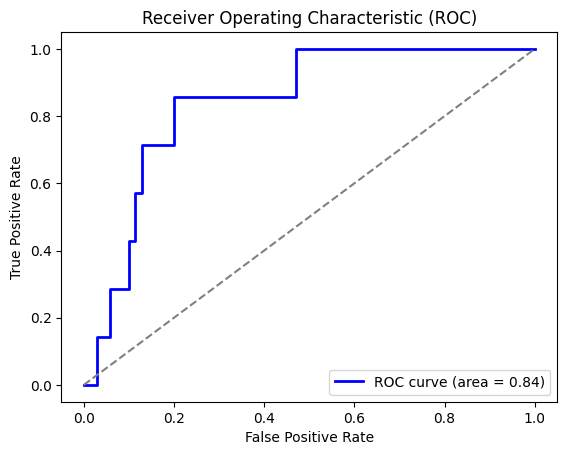

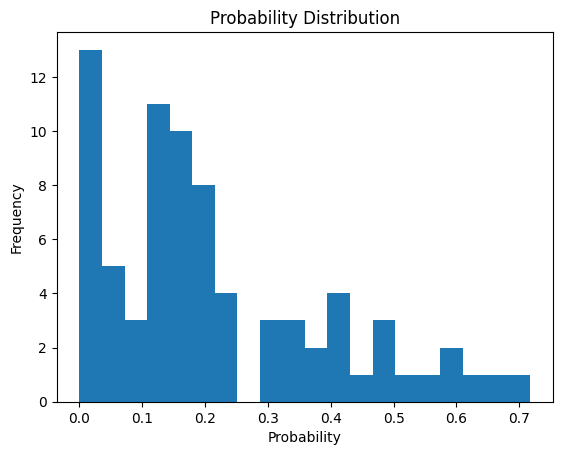

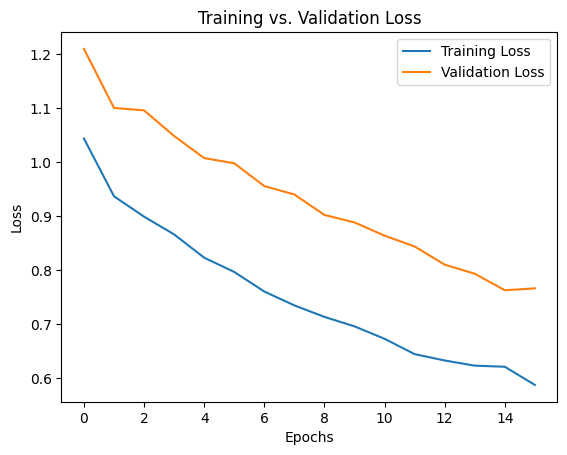

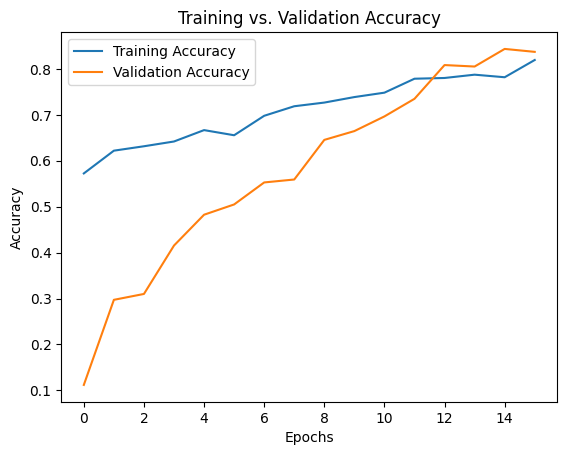

In [ ]:
# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

plt.hist(probabilities, bins=20)
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.show()




In [ ]:
# Convert the probabilities to a pandas DataFrame
probabilities_df = pd.DataFrame(probabilities, columns=['Probability'])

# Combine the probabilities with the original test data into a new DataFrame
new_df = pd.concat([X_test_original.reset_index(drop=True), probabilities_df], axis=1)

new_df = new_df[['DATE', 'PlayerID', 'Injury', 'Probability'] + list(metrics_train)]

# Display the first few rows to confirm
new_df.sort_values(by='DATE', ascending=False)

# Si lo queres ver en excel
# new_df.to_excel('probabilities_test.xlsx', index=False)

/home/codespace/.python/current/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_400
Received: inputs=['Tensor(shape=(100, 30))']
  warnings.warn(msg)
/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_400
Received: inputs=['Tensor(shape=(200, 30))']
  warnings.warn(m

SHAP values shape: (30, 1)
X_test_pca shape: (77, 30)
Expanded SHAP values shape: (77, 30)


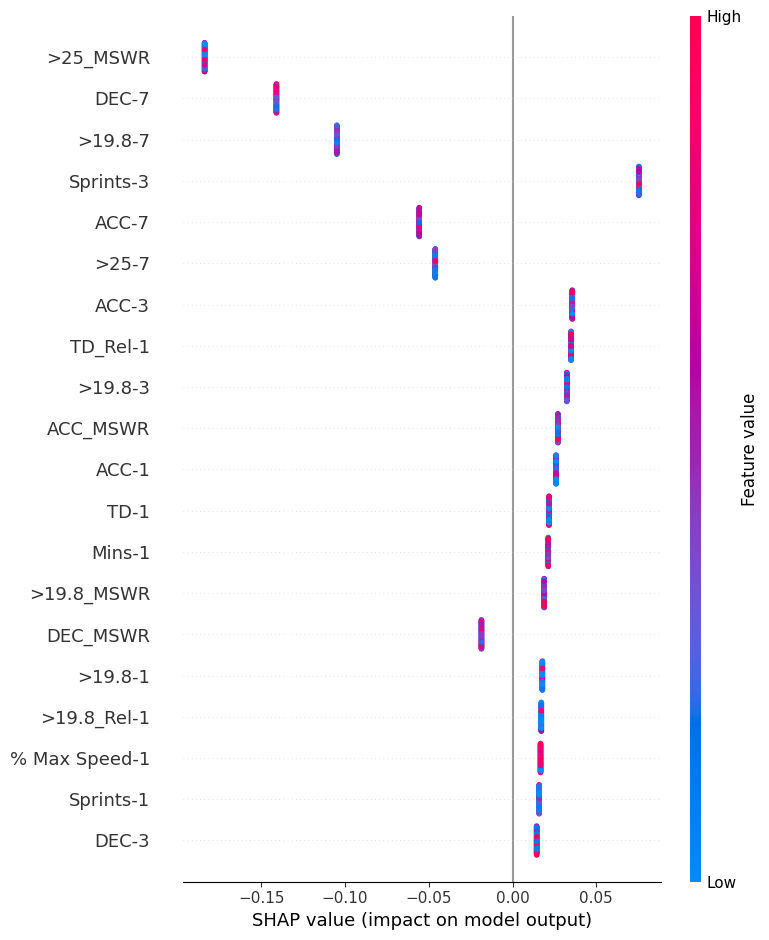

In [ ]:
# Initialize SHAP explainer
explainer = shap.DeepExplainer(model, X_train_pca[:100])

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_pca)
shap_values = shap_values[0]  # Extract contributions for the positive class

# Debugging shapes
print("SHAP values shape:", shap_values.shape)
print("X_test_pca shape:", X_test_pca.shape)

num_metrics = len(metrics_train)-1

# Adjust SHAP values if necessary
if shap_values.shape == (num_metrics, 1):
    shap_values = shap_values.T  # Adjust to (1, num_metrics)
if shap_values.shape == (1, num_metrics):
    shap_values = np.tile(shap_values, (X_test_pca.shape[0], 1))  # Expand to (77, 41)
    print("Expanded SHAP values shape:", shap_values.shape)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test_pca, feature_names=X_train.columns)

In [ ]:
# Step 1: Compute mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Step 2: Create a DataFrame to store feature importance
shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean SHAP Value': mean_shap_values
}).sort_values(by='Mean SHAP Value', ascending=False)

print("Feature importance:")
print(shap_importance)

Feature importance:
          Feature  Mean SHAP Value
27       >25_MSWR         0.183821
23          DEC-7         0.140956
20        >19.8-7         0.104885
18      Sprints-3         0.075396
22          ACC-7         0.055697
21          >25-7         0.046121
16          ACC-3         0.035658
6        TD_Rel-1         0.034924
14        >19.8-3         0.032402
28       ACC_MSWR         0.027085
3           ACC-1         0.025993
0            TD-1         0.021741
12         Mins-1         0.021310
26     >19.8_MSWR         0.018890
29       DEC_MSWR         0.018574
1         >19.8-1         0.017783
7     >19.8_Rel-1         0.017165
11  % Max Speed-1         0.016698
5       Sprints-1         0.015889
17          DEC-3         0.014376
25        TD_MSWR         0.013723
2           >25-1         0.013310
8       >25_Rel-1         0.013162
4           DEC-1         0.008353
19           TD-7         0.007593
24      Sprints-7         0.006404
9       ACC_Rel-1         0.005731


In [ ]:
# Step 3: Select the top X features
X = 15  # Number of top features to select
top_features = shap_importance['Feature'].head(X).tolist()

print(f"Top {X} features:", top_features)

Top 15 features: ['>25_MSWR', 'DEC-7', '>19.8-7', 'Sprints-3', 'ACC-7', '>25-7', 'ACC-3', 'TD_Rel-1', '>19.8-3', 'ACC_MSWR', 'ACC-1', 'TD-1', 'Mins-1', '>19.8_MSWR', 'DEC_MSWR']


## XGBoost Model

### Grid Search XGBoost

In [ ]:
# Updated base parameters with added regularization
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Expanded parameter grid
param_grid = {
    'learning_rate': [0.005, 0.007, 0.01],
    'max_depth': [7, 9, 11,13,15],
    'n_estimators': [300,500,700],
    'scale_pos_weight': [9,10,12,15],
    'alpha': [0],
    'gamma': [0],
}

scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train)
X_test_selected = scaler.transform(X_test)

model = XGBClassifier(**base_params_xgboost)

# Stratified K-Fold Cross-Validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',  # Optimize for ROC-AUC
    cv=stratified_cv,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the training dataset
grid_search.fit(X_train_selected, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_roc_auc = grid_search.best_score_

# Print best results
print(f"Best ROC-AUC (Grid Search): {best_roc_auc:.4f}")
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best ROC-AUC (Grid Search): 0.9987
Best Parameters: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 700, 'scale_pos_weight': 9}


## Manual XGBoost

Final Test ROC-AUC: 0.7020
Confusion Matrix:
[[53 17]
 [ 3  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84        70
           1       0.19      0.57      0.29         7

    accuracy                           0.74        77
   macro avg       0.57      0.66      0.56        77
weighted avg       0.88      0.74      0.79        77



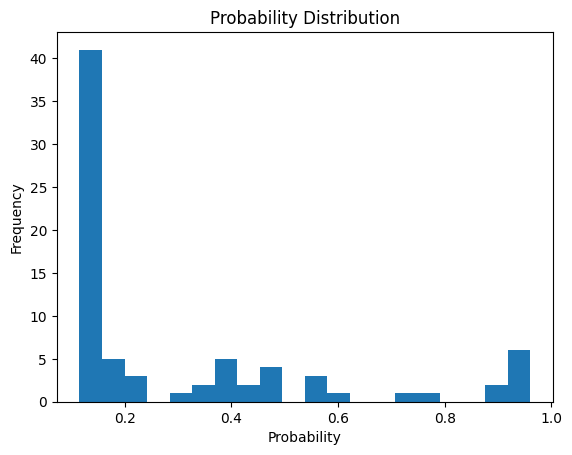

In [69]:
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.9
}

param_grid = {
  'learning_rate':0.005,  # Explore smaller learning rates
  'max_depth':11,            # Test broader depth values
  'n_estimators':400,     # Include larger estimators
  'scale_pos_weight': 9,
  'alpha': 0,  # L regularization
  'gamma': 0,  # Minimum loss reduction
}


X_train_scaled = X_train
X_test_scaled = X_test

# pca = PCA(n_components=30)  # Retain 95% of variance
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# Train the model with manually selected parameters
final_model = XGBClassifier(
    **base_params_xgboost,
    **param_grid,
)

# Train
final_model.fit(X_train_scaled,
                y_train,
                verbose=True
)

# Predict class labels (0 or 1) on the test set
y_pred_probs = final_model.predict_proba(X_test_scaled)[:, 1]
# Apply custom threshold
threshold = 0.4
y_pred = (y_pred_probs >= threshold).astype(int)

test_roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"Final Test ROC-AUC: {test_roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

plt.hist(y_pred_probs, bins=20)
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

In [70]:
# Get probabilities from XGBoost
xgboost_probabilities = y_pred_probs

# Convert the probabilities to a pandas DataFrame
xgboost_probabilities_df = pd.DataFrame(xgboost_probabilities, columns=['Probability'])

# Combine probabilities with X_test_original into a new DataFrame
new_xgboost_df = pd.concat([X_test_original.reset_index(drop=True), xgboost_probabilities_df], axis=1)

# Define the desired column order
column_order_xgboost = ['DATE', 'PlayerID', 'Injury', 'Probability'] + list(metrics_train)

# Ensure the columns exist in the new DataFrame and reorder them
new_xgboost_df = new_xgboost_df[[col for col in column_order_xgboost if col in new_xgboost_df.columns]]

# Display the first few rows to confirm
print(new_xgboost_df.head())

        DATE  PlayerID  Injury  Probability  Injury    TD-1  >19.8-1  >25-1  \
0 2022-11-23     89871       0     0.154344       0  5060.0        5      0   
1 2022-11-25     89871       0     0.158416       0     0.0        0      0   
2 2022-11-28     89871       0     0.156874       0     0.0        0      0   
3 2022-11-29     89871       0     0.375287       0  5770.0       69      4   
4 2022-11-30     89871       0     0.115234       0  4800.0       92      7   

   ACC-1  DEC-1  ...  >19.8-7  >25-7  ACC-7  DEC-7  Sprints-7   TD_MSWR  \
0   23.0   14.0  ...     69.0      0   46.0   23.0          0  0.571338   
1    0.0    0.0  ...    102.0      0   72.0   40.0          0  0.751186   
2    0.0    0.0  ...    198.0     97  150.0   69.0          4  0.999313   
3   52.0   30.0  ...    203.0    101  179.0   90.0          4  1.043036   
4   39.0   23.0  ...    290.0    108  195.0   99.0          4  1.039031   

   >19.8_MSWR  >25_MSWR  ACC_MSWR  DEC_MSWR  
0    0.411617  0.000000  0.5

In [71]:
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(final_model)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test_scaled)

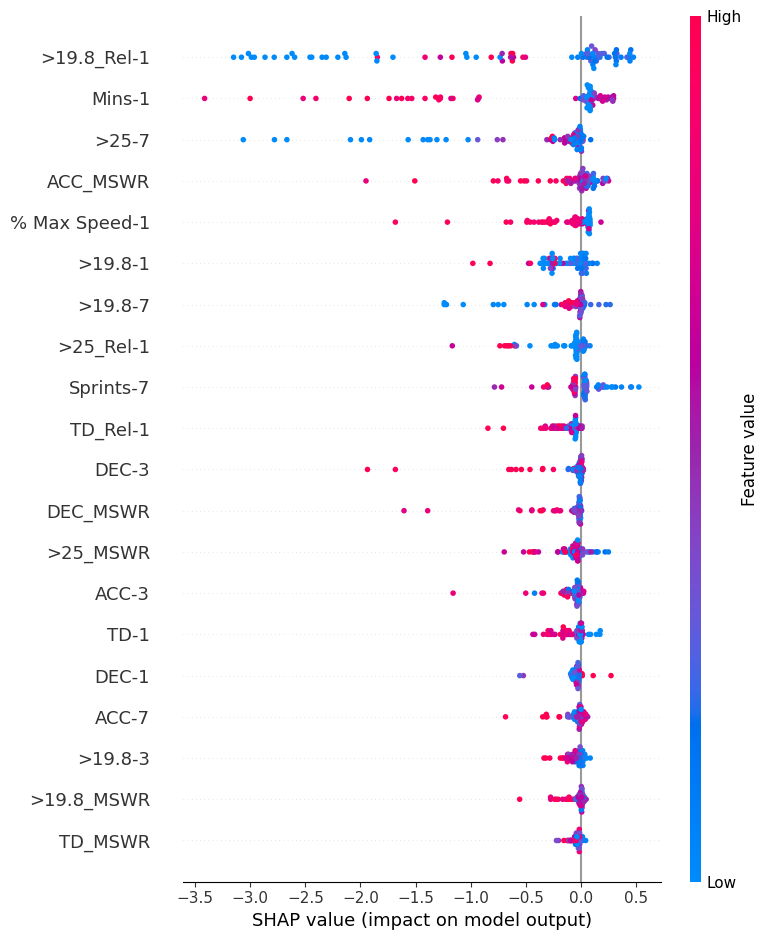

In [72]:
shap.summary_plot(shap_values, X_test_scaled)

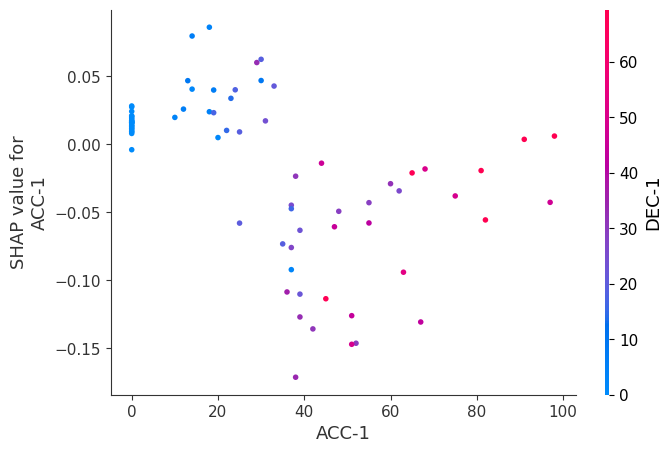

In [73]:
shap.dependence_plot("ACC-1", shap_values, X_test, interaction_index="DEC-1")

### Prepare the data to export in excel

Categorize the percentages into levels of risk

In [ ]:
def categorize_risk(percentage):
    if percentage < 40:
        return 'Low Risk'
    elif 40 <= percentage < 70:
        return 'Medium Risk'
    else:
        return 'High Risk'